<a href="https://colab.research.google.com/github/medYousseffathallah/demand-forecast/blob/main/compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pickle
import joblib
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
import joblib, json

# Load models
rf_model = joblib.load("/content/saved_models/random_forest.pkl")
lr_model = joblib.load("/content/saved_models/linear_regression.pkl")

# Load config
with open("/content/saved_models/config.json", "r") as f:
    config = json.load(f)

print("Features used:", config["feature_names"])
print("Time steps required:", config["time_steps"])


Features used: ['daily_quantity', 'day_of_week', 'month', 'lag_7', 'rolling_mean_7', 'is_weekend']
Time steps required: 60


In [ ]:
df=pd.read_csv("/content/saved_models/daily_demand_by_product_store.csv")

In [ ]:
def backtest_last_n_days(df, model, store_id, item_id, n_days=10, time_steps=60):

    group = df[(df["store_id"] == store_id) & (df["item_id"] == item_id)].copy()
    group = group.sort_values("date").reset_index(drop=True)

    group["date"] = pd.to_datetime(group["date"])

    # features
    group["day_of_week"] = group["date"].dt.dayofweek
    group["month"] = group["date"].dt.month
    group["lag_7"] = group["daily_quantity"].shift(7)
    group["rolling_mean_7"] = group["daily_quantity"].shift(1).rolling(window=7, min_periods=1).mean()
    group["is_weekend"] = (group["day_of_week"] >= 5).astype(int)

    feature_cols = config["feature_names"]
    results = []

    for i in range(len(group) - n_days, len(group)):
        # Take history window (previous 60 days)
        start_idx = i - time_steps
        end_idx = i

        if start_idx < 0:
            continue

        history = group.iloc[start_idx:end_idx]
        X_seq = history[feature_cols].values

        # Reshape for model
        X_input = np.expand_dims(X_seq, axis=0)
        X_input_flat = X_input.reshape(1, -1)

        # Predict
        pred = model.predict(X_input_flat)[0]
        actual = group.iloc[i]["daily_quantity"]

        results.append({
            "date": group.iloc[i]["date"],
            "store_id": store_id,
            "item_id": item_id,
            "actual": actual,
            "forecast": pred
        })

    return pd.DataFrame(results)


In [ ]:
results = backtest_last_n_days(df, rf_model, store_id=1, item_id=1, n_days=10)

print(results)

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(results["actual"], results["forecast"])
rmse = mean_squared_error(results["actual"], results["forecast"])

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
results4 = backtest_last_n_days(df, lr_model, store_id=1, item_id=1, n_days=10)

print(results4)

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(results4["actual"], results4["forecast"])
rmse = mean_squared_error(results4["actual"], results4["forecast"])

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")


        date  store_id  item_id  actual  forecast
0 2025-06-21         1        1    1007   1006.24
1 2025-06-22         1        1    1024   1012.04
2 2025-06-23         1        1     992    990.16
3 2025-06-24         1        1     961    976.77
4 2025-06-25         1        1    1035   1020.49
5 2025-06-26         1        1    1069   1037.79
6 2025-06-27         1        1     954    975.37
7 2025-06-28         1        1     949    971.94
8 2025-06-29         1        1    1007   1005.16
9 2025-06-30         1        1    1042   1030.43
MAE: 13.3770, RMSE: 270.0473
        date  store_id  item_id  actual     forecast
0 2025-06-21         1        1    1007   999.375180
1 2025-06-22         1        1    1024  1003.963121
2 2025-06-23         1        1     992   999.673705
3 2025-06-24         1        1     961   998.019279
4 2025-06-25         1        1    1035   999.195265
5 2025-06-26         1        1    1069  1001.534097
6 2025-06-27         1        1     954  1003.0145

In [ ]:
import joblib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

class DemandForecastModel:
    def __init__(self, model_path):
        self.model_package = joblib.load('sgboost_demand_forecast_model.pkl')
        self.model = self.model_package['model']
        self.metadata = self.model_package['metadata']

    def prepare_input_data(self, historical_data):

        required_cols = self.metadata['required_columns']
        if not all(col in historical_data.columns for col in required_cols):
            raise ValueError(f"Missing required columns. Expected: {required_cols}")

        data = historical_data.copy()
        data['date'] = pd.to_datetime(data['date'])

        data['day_of_week'] = data['date'].dt.dayofweek
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['week_of_year'] = data['date'].dt.isocalendar().week
        data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

        data = data.sort_values(['store_id', 'item_id', 'date'])

        data = data.groupby(['store_id', 'item_id']).apply(
            lambda x: x.assign(
                lag_7=x['daily_quantity'].shift(7),
                lag_14=x['daily_quantity'].shift(14),
                lag_28=x['daily_quantity'].shift(28),
                rolling_mean_7=x['daily_quantity'].shift(1).rolling(window=7, min_periods=1).mean(),
                rolling_std_7=x['daily_quantity'].shift(1).rolling(window=7, min_periods=1).std()
            )
        ).reset_index(drop=True)

        return data

    def create_sequences(self, prepared_data):
        """Create sequences in the same format as training"""
        sequences = []
        feature_columns = self.metadata['feature_columns']
        time_steps = self.metadata['time_steps']

        grouped = prepared_data.groupby(['store_id', 'item_id'])

        for (store_id, item_id), group in grouped:
            group = group.sort_values('date').dropna()

            if len(group) >= time_steps:
                recent_data = group.tail(time_steps)
                sequence = recent_data[feature_columns].values
                sequences.append(sequence)

        if sequences:
            sequences_array = np.array(sequences)
            flattened = sequences_array.reshape(sequences_array.shape[0], -1)
            return flattened
        else:
            raise ValueError("Insufficient historical data for prediction")

    def predict(self, historical_data):
        # Prepare the data
        prepared_data = self.prepare_input_data(historical_data)

        # Create sequences
        X_input = self.create_sequences(prepared_data)

        # Make predictions
        predictions = self.model.predict(X_input)

        return predictions



/tmp/ipython-input-2447490651.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['store_id', 'item_id']).apply(


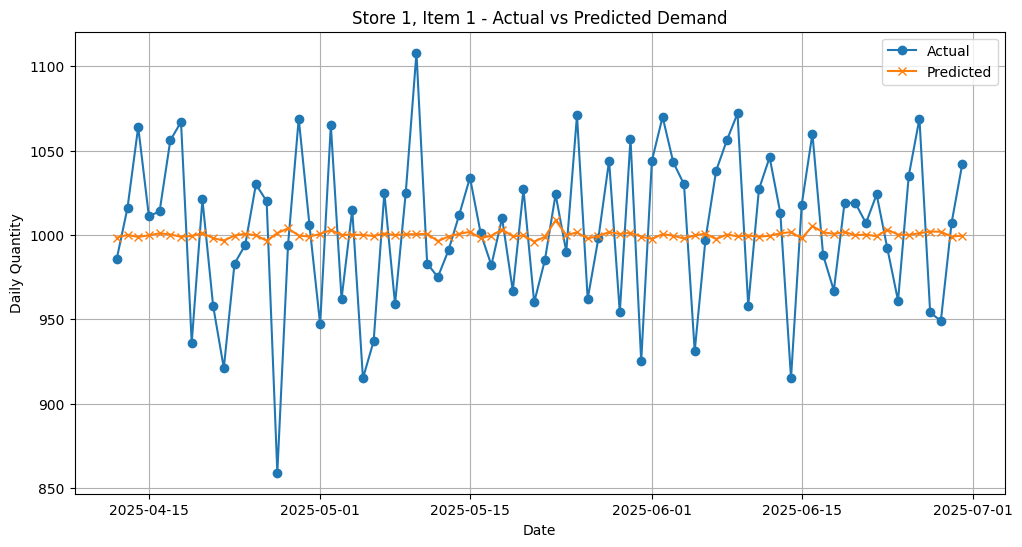

Mean Absolute Error (Store 1, Item 1): 37.25


/tmp/ipython-input-2447490651.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['store_id', 'item_id']).apply(


In [ ]:
model = DemandForecastModel('sgboost_demand_forecast_model.pkl')

import matplotlib.pyplot as plt

historical_data = df.copy()
historical_data = historical_data[['store_id', 'item_id', 'date', 'daily_quantity']]
historical_data['date'] = pd.to_datetime(historical_data['date'])

# Get predictions
predictions = model.predict(historical_data)

store_id, item_id = 1, 1
subset = historical_data[(historical_data['store_id'] == store_id) &
                         (historical_data['item_id'] == item_id)].sort_values('date')

time_steps = model.metadata['time_steps']
subset = subset.tail(len(predictions))

subset['predicted_quantity'] = predictions

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(subset['date'], subset['daily_quantity'], label="Actual", marker='o')
plt.plot(subset['date'], subset['predicted_quantity'], label="Predicted", marker='x')
plt.xlabel("Date")
plt.ylabel("Daily Quantity")
plt.title(f"Store {store_id}, Item {item_id} - Actual vs Predicted Demand")
plt.legend()
plt.grid(True)
plt.show()
mae = mean_absolute_error(subset['daily_quantity'], subset['predicted_quantity'])
print(f"Mean Absolute Error (Store {store_id}, Item {item_id}): {mae:.2f}")
predictions = model.predict(historical_data)


